In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unseen-images/unseen_images/Clear/uc5.jpg
/kaggle/input/unseen-images/unseen_images/Clear/uc3.jpg
/kaggle/input/unseen-images/unseen_images/Clear/uc1.jpg
/kaggle/input/unseen-images/unseen_images/Clear/uc4.jpg
/kaggle/input/unseen-images/unseen_images/Clear/uc2.jpg
/kaggle/input/unseen-images/unseen_images/Blocked/u5.jpg
/kaggle/input/unseen-images/unseen_images/Blocked/u2.jpg
/kaggle/input/unseen-images/unseen_images/Blocked/u1.jpg
/kaggle/input/unseen-images/unseen_images/Blocked/u3.jpg
/kaggle/input/unseen-images/unseen_images/Blocked/ucovered1.jpg
/kaggle/input/unseen-images/unseen_images/Blocked/u4.jpg
/kaggle/input/drainage-images/Dataset/Clear/culverts/c12.jpg
/kaggle/input/drainage-images/Dataset/Clear/culverts/c14.jpg
/kaggle/input/drainage-images/Dataset/Clear/culverts/c7.jpg
/kaggle/input/drainage-images/Dataset/Clear/culverts/c15.jpg
/kaggle/input/drainage-images/Dataset/Clear/culverts/c13.jpg
/kaggle/input/drainage-images/Dataset/Clear/culverts/c16.jpg
/kaggl

In [2]:
!pip install tensorflow pillow matplotlib numpy

In [3]:
#Loads and Inspects the dataset

import os
from collections import defaultdict

data_dir = '/kaggle/input/drainage-images/Dataset'  
classes = os.listdir(data_dir)  

# Count images per subclass
subclass_counts = defaultdict(int)

for main_class in classes:
    subclass_dir = os.path.join(data_dir, main_class)
    subclasses = os.listdir(subclass_dir)
    for sub in subclasses:
        path = os.path.join(subclass_dir, sub)
        count = len(os.listdir(path))
        subclass_counts[f"{main_class}/{sub}"] = count

# Display counts
for k,v in subclass_counts.items():
    print(f"{k}: {v} images")


Clear/culverts: 11 images
Clear/closed: 4 images
Clear/open: 9 images
Blocked/vegetation_growth: 1 images
Blocked/damaged and blocked: 2 images
Blocked/waste: 21 images
Blocked/debris: 1 images


In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter


In [5]:
#EDA(main classes and subclasses)

data_dir = '/kaggle/input/drainage-images/Dataset'

main_classes = os.listdir(data_dir)
print("Main classes:", main_classes)

for cls in main_classes:
    subclasses = os.listdir(os.path.join(data_dir, cls))
    print(f"Subclasses under {cls}: {subclasses}")


Main classes: ['Clear', 'Blocked']
Subclasses under Clear: ['culverts', 'closed', 'open']
Subclasses under Blocked: ['vegetation_growth', 'damaged and blocked', 'waste', 'debris']


In [6]:
#Count images per class and subclass

class_counts = {}
for cls in main_classes:
    class_counts[cls] = {}
    subclasses = os.listdir(os.path.join(data_dir, cls))
    for sub in subclasses:
        path = os.path.join(data_dir, cls, sub)
        class_counts[cls][sub] = len(os.listdir(path))

print(class_counts)


{'Clear': {'culverts': 11, 'closed': 4, 'open': 9}, 'Blocked': {'vegetation_growth': 1, 'damaged and blocked': 2, 'waste': 21, 'debris': 1}}


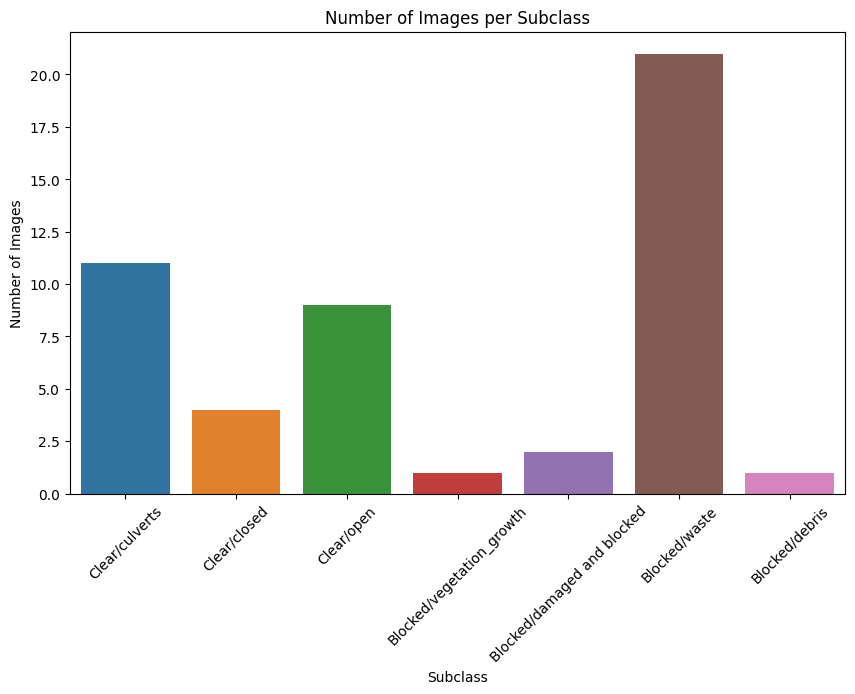

In [7]:
#To detect Imbalances

# Flatten dict for plotting
flat_counts = {f"{cls}/{sub}": count for cls, subs in class_counts.items() for sub, count in subs.items()}

# Converts to DataFrame
df_counts = pd.DataFrame({
    "Subclass": list(flat_counts.keys()),
    "Count": list(flat_counts.values())
})

plt.figure(figsize=(10,6))
sns.barplot(data=df_counts, x="Subclass", y="Count")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.title("Number of Images per Subclass")
plt.show()


In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


Average width: 316.2040816326531
Average height: 218.9591836734694
Width range: 177 to 1620
Height range: 134 to 1080


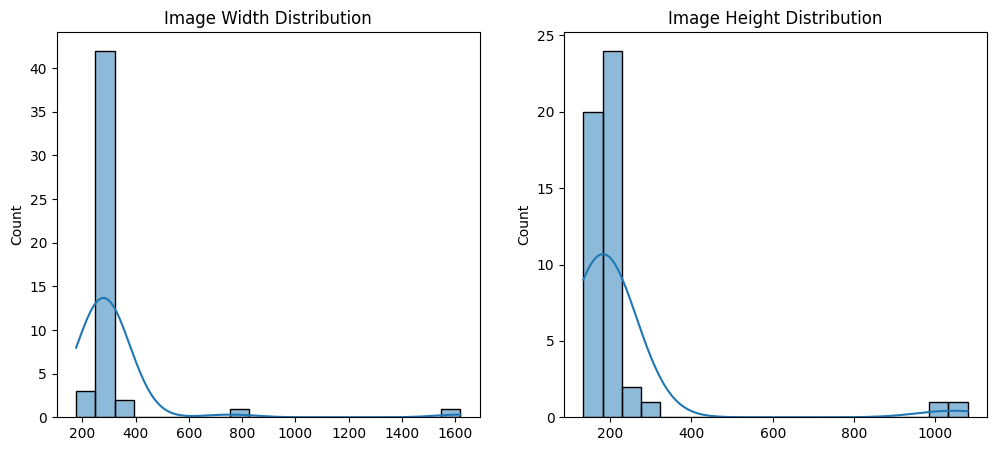

In [9]:
#Is resizing needed?

widths, heights = [], []
for cls in main_classes:
    subclasses = os.listdir(os.path.join(data_dir, cls))
    for sub in subclasses:
        path = os.path.join(data_dir, cls, sub)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path)
            widths.append(img.width)
            heights.append(img.height)

print("Average width:", np.mean(widths))
print("Average height:", np.mean(heights))
print("Width range:", min(widths), "to", max(widths))
print("Height range:", min(heights), "to", max(heights))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Image Width Distribution")
plt.subplot(1,2,2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Image Height Distribution")
plt.show()


In [10]:
#Understand brightness/contrast distribution

pixel_means, pixel_stds = [], []
for cls in main_classes:
    subclasses = os.listdir(os.path.join(data_dir, cls))
    for sub in subclasses:
        path = os.path.join(data_dir, cls, sub)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, sub)
            img = Image.open(os.path.join(path, img_name)).convert('RGB')
            img_array = np.array(img)/255.0  # normalize
            pixel_means.append(np.mean(img_array))
            pixel_stds.append(np.std(img_array))

print("Average pixel value mean:", np.mean(pixel_means))
print("Average pixel value std:", np.mean(pixel_stds))


Average pixel value mean: 0.4725366715698547
Average pixel value std: 0.23298589251924917


In [11]:
# Class Imbalance ratio

total_images = sum(flat_counts.values())
for k,v in flat_counts.items():
    print(f"{k}: {v/total_images:.2f}")  # percentage per subclass


Clear/culverts: 0.22
Clear/closed: 0.08
Clear/open: 0.18
Blocked/vegetation_growth: 0.02
Blocked/damaged and blocked: 0.04
Blocked/waste: 0.43
Blocked/debris: 0.02


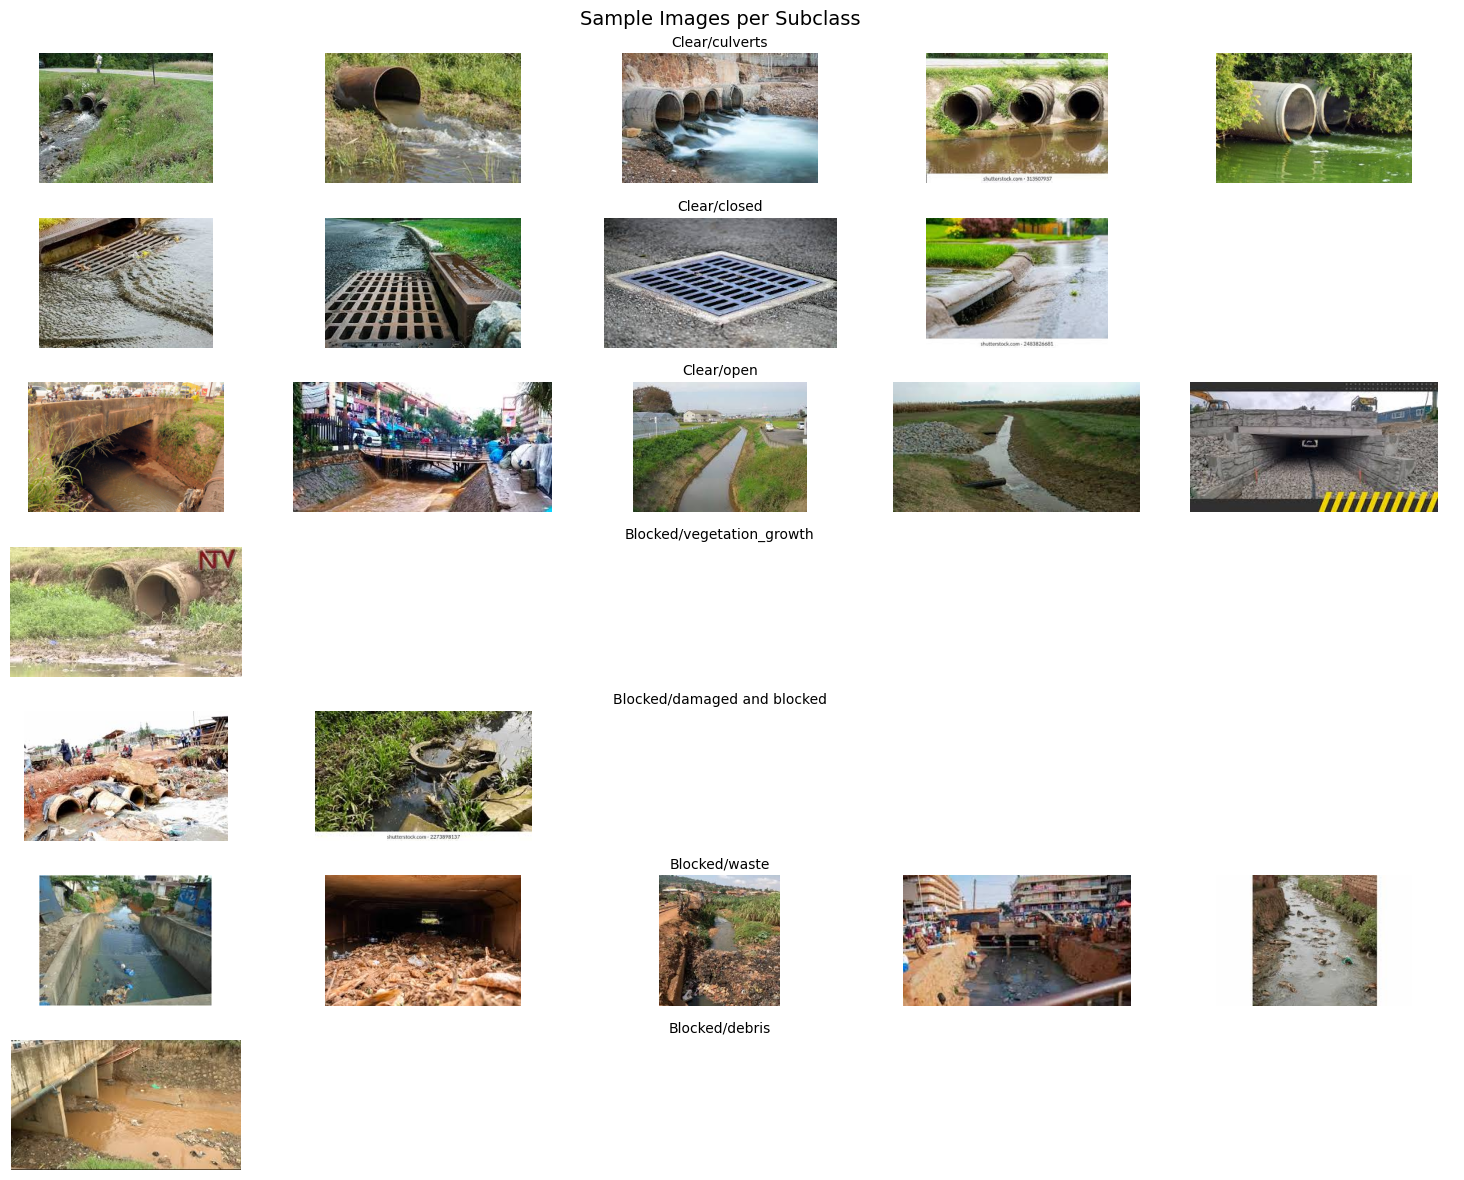

In [12]:
#Visualize images per subclass

fig, axes = plt.subplots(len(flat_counts), 5, figsize=(15,12))

#Avoids dimension mismatch
if len(flat_counts) == 1:
    axes = [axes]

for i, (subcls, count) in enumerate(flat_counts.items()):
    cls, sub = subcls.split('/')
    path = os.path.join(data_dir, cls, sub)
    imgs = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]  # first 5 images
    
    for j in range(5):
        ax = axes[i][j]
        ax.axis('off')
        if j < len(imgs):
            img_path = os.path.join(path, imgs[j])
            try:
                img = Image.open(img_path).convert("RGB")  # proper color format
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, 'Error\nLoading', ha='center', va='center', fontsize=8)
        if j == 2:
            ax.set_title(subcls, fontsize=10)
            
            
plt.suptitle("Sample Images per Subclass", fontsize=14)
plt.tight_layout()
plt.show()


In [13]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory


2025-10-17 06:41:58.684200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760683318.881501      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760683318.935389      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:

# 1️⃣ Dataset paths
# ---------------------------
train_val_dir = "/kaggle/input/drainage-images/Dataset"  # Folder containing Blocked & Clear
test_dir = "/kaggle/input/unseen-images/unseen_images"  # Unseen test data folder


# 2️⃣ Load train and validation datasets (80/20 split)
# ---------------------------
train_ds = image_dataset_from_directory(
    train_val_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=16
)

val_ds = image_dataset_from_directory(
    train_val_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=16
)

# ---------------------------
# 3️⃣ Load test dataset (unseen data)
# ---------------------------
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=16
)


Found 49 files belonging to 2 classes.
Using 40 files for training.


I0000 00:00:1760683329.937103      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 49 files belonging to 2 classes.
Using 9 files for validation.
Found 11 files belonging to 2 classes.


In [15]:
#Saves the class names before mapping
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['Blocked', 'Clear']


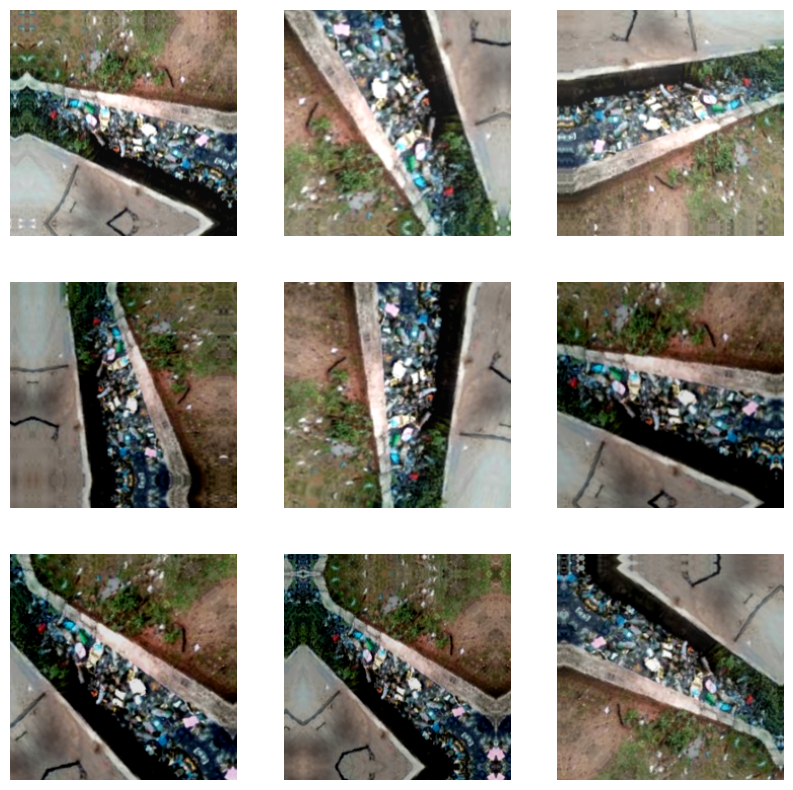

In [16]:
#Augments the images

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),     
    layers.RandomTranslation(0.05, 0.05),
    
])

rescale_only = tf.keras.Sequential([
    layers.Rescaling(1./255)
]) #rescaling for validation and test/no augmentation


# Load images
image_path = "/kaggle/input/drainage-images/Dataset/Blocked/waste/22.jpg"
img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Adds batch dimension


# Apply augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(img_array)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
#lets apply augmentation to training data

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

#No augmentation on validate and test
val_ds = val_ds.map(lambda x, y: (rescale_only(x), y))
test_ds = test_ds.map(lambda x, y: (rescale_only(x), y))

#Improve performance WITH Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
rescale_layer = layers.Rescaling(1./255)

In [19]:
#Builds the cnn model

def build_simple_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(224, 224,3)),
        data_augmentation,
        rescale_layer,
        
        layers.Conv2D(32, 3, activation='relu', padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3), 
        
        layers.Conv2D(64, 3, activation='relu', padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        
        layers.Conv2D(128, 3, activation='relu', padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling2D(), # For Fewer parameters 
        layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [20]:
#Builds MobileNetV2 model

def build_mobilenetv2():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
   #freeze most of the layers
    for layer in base_model.layers:
        layer.trainable = False 


    model = tf.keras.Sequential([
        data_augmentation,
        rescale_layer,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [21]:
#Builds ResNet50 model

def build_resnet50():
    base_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    #Freezez all but last 50layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    
   
    
    model = tf.keras.Sequential([
        data_augmentation,
        rescale_layer,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [22]:
#Training function for all 3 models

def train_and_evaluate(model, train_ds, val_ds, epochs=15, class_weight=None, learning_rate=1e-4):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    #for robustness and efficient fine tuning
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose = 1),

         tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1),
        tf.keras.callbacks.CSVLogger('training_log.csv', append=False) #saves metrics per epoch
        
    ]

    
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weight, callbacks=callbacks)
    return history

#Collect all labels from train_ds
labels = []
for _, lbls in train_ds:
    labels.extend(lbls.numpy())

# Compute class weights
class_weights_values = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: w for i, w in enumerate(class_weights_values)}
print("Class weights:", class_weights)

Class weights: {0: 0.9523809523809523, 1: 1.0526315789473684}


In [23]:
#Trains all three models 

simple_cnn = build_simple_cnn()
mobilenetv2 = build_mobilenetv2()
resnet = build_resnet50()

print("Training Simple CNN...")
cnn_history = train_and_evaluate(simple_cnn, train_ds, val_ds, epochs=15, class_weight=class_weights)

print("Training MobileNetV2...")
mobilenet_history = train_and_evaluate(mobilenetv2, train_ds, val_ds, epochs=15, class_weight=class_weights)

print("Training ResNet...")
resnet_history = train_and_evaluate(resnet, train_ds, val_ds, epochs=15, class_weight=class_weights)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Simple CNN...
Epoch 1/15


E0000 00:00:1760683346.581123      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1760683347.617848      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5396 - loss: 1.0392 - precision: 0.5417 - recall: 0.5782
Epoch 1: val_loss improved from inf to 0.71991, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 678ms/step - accuracy: 0.5359 - loss: 1.0577 - precision: 0.5312 - recall: 0.5784 - val_accuracy: 0.4444 - val_loss: 0.7199 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5208 - loss: 1.1346 - precision: 0.4637 - recall: 0.5754
Epoch 2: val_loss did not improve from 0.71991
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.5156 - loss: 1.1377 - precision: 0.4669 - recall: 0.5632 - val_accuracy: 0.4444 - val_loss: 0.7201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4375 - loss: 1.0519 - precision: 0.3950 - recall: 0.3665
Epoch 3: ReduceLROnPlateau reducing learning rate to 

In [24]:
# Final validation accuracy for each model
val_accuracies = [
    cnn_history.history['val_accuracy'][-1],        # Simple CNN
    mobilenet_history.history['val_accuracy'][-1],  # MobileNetV2
    resnet_history.history['val_accuracy'][-1]      # ResNet18
]

model_names = ['Simple CNN', 'MobileNetV2', 'ResNet50']

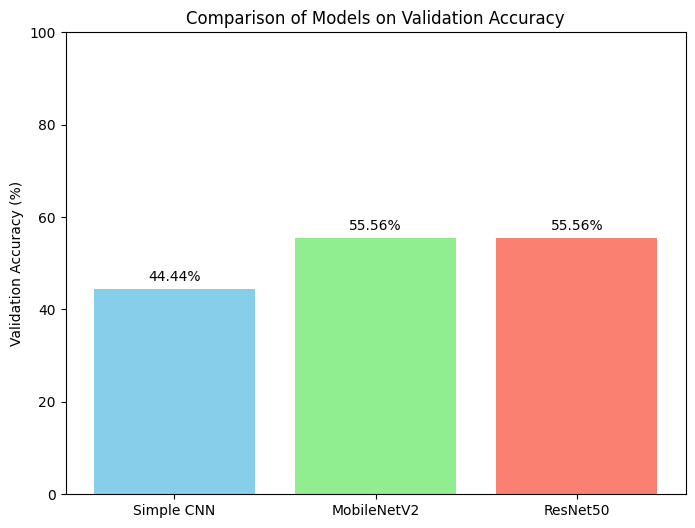

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
bars = plt.bar(model_names, [acc*100 for acc in val_accuracies], color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 100)
plt.ylabel('Validation Accuracy (%)')
plt.title('Comparison of Models on Validation Accuracy')

# Add accuracy labels on top of bars
for bar, acc in zip(bars, val_accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{acc*100:.2f}%', ha='center', va='bottom')

plt.show()


In [26]:
#Test on unseen data

cnn_test_acc = simple_cnn.evaluate(test_ds)[1]
mobilenet_test_acc = mobilenetv2.evaluate(test_ds)[1]
resnet_test_acc = resnet.evaluate(test_ds)[1]

print("Simple CNN Test Accuracy:", cnn_test_acc)
print("MobileNetV2 Test Accuracy:", mobilenet_test_acc)
print("ResNet Test Accuracy:", resnet_test_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5455 - loss: 0.7190 - precision: 0.0000e+00 - recall: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4545 - loss: 0.9292 - precision_1: 0.4545 - recall_1: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.4545 - loss: 0.7889 - precision_2: 0.4545 - recall_2: 1.0000
Simple CNN Test Accuracy: 0.5454545617103577
MobileNetV2 Test Accuracy: 0.4545454680919647
ResNet Test Accuracy: 0.4545454680919647


In [27]:
#Predict whether blocked or clear

best_model = mobilenetv2  

# Load an unseen image
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

img_path = "/kaggle/input/unseen-images/unseen_images/Clear/uc1.jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = best_model.predict(img_array)
pred_class = int(pred[0][0] > 0.5 ) #For sigmoid output
print("Predicted class:",class_names[pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Clear


In [28]:
#Predict whether blocked or clear

best_model = mobilenetv2  

# Load an unseen image
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

img_path = "/kaggle/input/unseen-images/unseen_images/Blocked/u3.jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = best_model.predict(img_array)
pred_class = int(pred[0][0] <= 0.5 ) #For sigmoid output
print("Predicted class:",class_names[pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: Blocked
